<i>Solution accomplished by Maksim Kumundzhiev (V249C6)</i> 


### Donwload Data

In [3]:
# Obtain data
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" > /dev/null 
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" -o CAT_00.zip 
!unzip CAT_00.zip
!rm CAT_00.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4121      0 --:--:-- --:--:-- --:--:--  4121
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  402M    0  402M    0     0   100M      0 --:--:--  0:00:04 --:--:--  120M
Archive:  CAT_00.zip
   creating: CAT_00/
 extracting: CAT_00/00000001_000.jpg  
  inflating: CAT_00/00000001_000.jpg.cat  
 extracting: CAT_00/00000001_005.jpg  
  inflating: CAT_00/00000001_005.jpg.cat  
 extracting: CAT_00/00000001_008.jpg  
  inflating: CAT_00/00000001_008.jpg.cat  
 extracting: CAT_00/00000001_011.jpg  
  inflating: CAT_00/00000001_011.jpg.cat  
 extracting: CAT_00/00000001_012.jpg  
  inflating: CAT_00/00000001_012.jpg.cat  
 extracting: CAT_00/00000001_016.jpg  
  inflating: CAT_00/00000001_016.jp

### Imports

In [153]:
import os
from glob import glob

import cv2
import math
import skimage
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Obtain Original Images 

In [154]:
TARGET_PATH = 'CAT_00'

def get_original_images(dir_path: str):
    original_images_paths = []
    original_images = []
    [original_images_paths.append(path) for path in glob(f'{TARGET_PATH}/*.jpg')]
  
    for image_path in original_images_paths:
      original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      casted_original_image = np.array(original_image)
      original_images.append(casted_original_image)
    return sorted(original_images_paths), original_images

original_images_paths, original_images = get_original_images(TARGET_PATH)

### Plot Few of Original Images

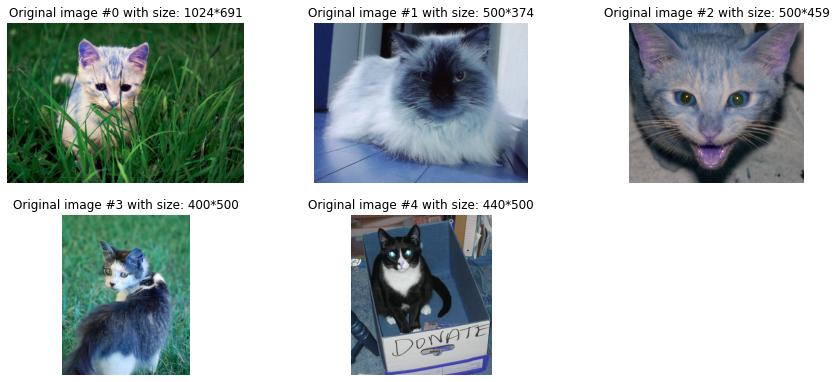

In [155]:
# Plot original images 

plt.figure(figsize=(15, 10))

for index in range(5):
  w, h = original_images[index].shape[0], original_images[index].shape[1]
  plt.subplot(3, 3, index+1)
  plt.title(f'Original image #{index} with size: {h}*{w}')
  plt.imshow(original_images[index])
  plt.axis('off')
  

## DataSet Preparation

In [157]:
def resize_img(im, img_size):
  """ Resize input image with provided by user input.
  
  Notes:
     source: https://github.com/kairess/cat_hipsterizer/blob/master/preprocess.py 

  Returns:
     new_im, ratio, top, left
  """

  old_size = im.shape[:2] 
  ratio = float(img_size) / max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  im = cv2.resize(im, (new_size[1], new_size[0]))
  delta_w = img_size - new_size[1]
  delta_h = img_size - new_size[0]
  top, bottom = delta_h // 2, delta_h - (delta_h // 2)
  left, right = delta_w // 2, delta_w - (delta_w // 2)
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  return new_im, ratio, top, left


def apply_gaussian(xL, yL, H, W, sigma=5):
  channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
  channel = np.array(channel, dtype=np.float32)
  channel = np.reshape(channel, newshape=(H, W))
  channel = cv2.GaussianBlur(channel, (5,5), 0)
  return channel


def get_mask(height, width, landmarks, s=3):
        """ Generate a full Heap Map for every landmarks in an array

        Arguments:
          width: width of target output
          height: height of target output
          joints: [(x1,y1),(x2,y2)...] containing landmarks
          s: denote sigma
        """

        def get_gaussian_kernel(x0, y0, sigma, width, height):
          """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
          """

          x = np.arange(0, width, 1, float) 
          y = np.arange(0, height, 1, float)[:, np.newaxis]
          result = np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
          return result
        
        landmarks_number = len(landmarks)
        heatmap = np.zeros((height, width, landmarks_number), dtype = np.float32)
        for i in range(landmarks_number):
            if not np.array_equal(landmarks[i], [-1,-1]):
                heatmap[:,:,i] = get_gaussian_kernel(landmarks[i][0], landmarks[i][1], s, height, width)
            else:
                heatmap[:,:,i] = np.zeros((height,width))
        return heatmap

In [159]:
files_list = sorted(os.listdir(TARGET_PATH))

images_dataset = []
masks_dataset = []

dataset = {
  'images': [],
  'images_masks': [],
  'landmarks': [],
  'bounding_boxes': []
}

for file_name in files_list:
  if '.cat' not in file_name:
    continue

  pd_frame = pd.read_csv(os.path.join(TARGET_PATH, file_name), sep=' ', header=None)
  landmarks = (pd_frame.values[0][1:7]).reshape((-1, 2))      

  img_filename, ext = os.path.splitext(file_name)
  img = cv2.imread(os.path.join(TARGET_PATH, img_filename))

  img, ratio, top, left = resize_img(img, 128)
  landmarks = ((landmarks * ratio) + np.array([left, top])).astype(np.int)
  bb = np.array([np.min(landmarks, axis=0), np.max(landmarks, axis=0)])

  heatmaps = []
  for landmark in landmarks:
     heatmap = apply_gaussian(landmark[0], landmark[1], 128, 128)
     heatmaps.append(heatmap)
  
  heatmaps = np.array(heatmaps)
  image_mask = get_mask(128, 128, landmarks, 5)

  x1, y1, x2, y2 = bb.flatten()                     
  if x1 > 20 and y1 > 20:
      x1, y1, x2, y2 = x1-20, y1-20, x2+20, y2+20       

  heatmaps = heatmaps.sum(axis=0)

  img = img[y1:y2, x1:x2]                 
  image_mask = image_mask[y1:y2, x1:x2]

  img, ratio, top, left = resize_img(img, 64)
  landmarks = ((landmarks * ratio) + np.array([left, top])).astype(np.int)
  bb = np.array([np.min(landmarks, axis=0), np.max(landmarks, axis=0)])
  image_mask, ratio, top, left = resize_img(image_mask, 64)

  dataset['landmarks'].append(landmarks.flatten())  
  dataset['bounding_boxes'].append(bb.flatten())           
  dataset['images'].append(img)                  
  dataset['images_masks'].append(image_mask)

  images_dataset.append(img)
  masks_dataset.append(image_mask)

### Split Data on Training & Vlidation & Test

In [167]:
all_images = np.array(cat_images)
all_masks = np.array(cat_himages)

train_data, test_data, train_label, test_label = train_test_split(all_images, all_masks, test_size=.2)
train_data, valid_data, train_label, valid_label = train_test_split(all_images, all_masks, test_size=.25)

print('Training', train_data.shape[0])
print('Validation', valid_data.shape[0])
print('Test', test_data.shape[0])

Training 1279
Validation 427
Test 342


### Plot Processed Image and Corresponding Mask

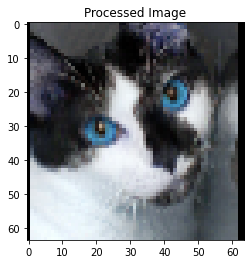

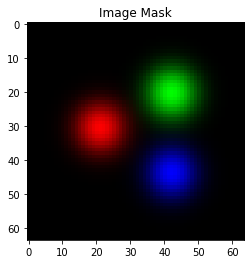

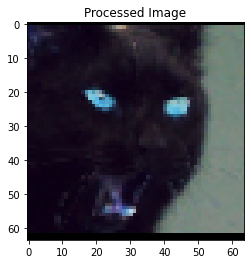

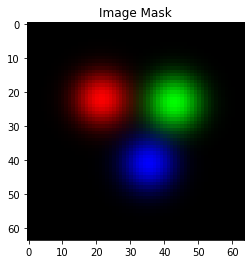

In [168]:
selected_images_indexes = np.random.choice(100, 2)

for _, image_index in enumerate(selected_images_indexes):
  plt.title("Processed Image")
  plt.imshow(train_data[image_index]);
  plt.show()

  plt.title("Image Mask")
  plt.imshow(train_label[image_index])
  plt.show()

### Normalise data

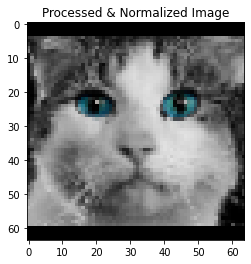

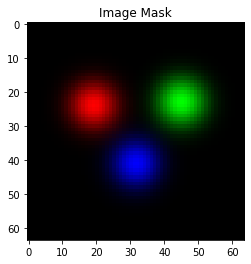

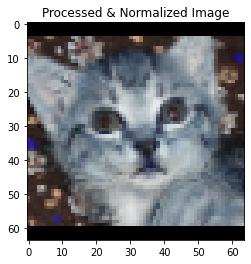

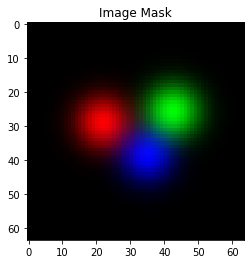

In [171]:
X_train_norm = (train_data / 255)
X_val_norm = (valid_data / 255)
X_test_norm = (test_data / 255)


selected_images_indexes = np.random.choice(100, 2)

for _, image_index in enumerate(selected_images_indexes):
  plt.title("Processed & Normalized Image")
  plt.imshow(X_train_norm[image_index]);
  plt.show()

  plt.title("Image Mask")
  plt.imshow(train_label[image_index])
  plt.show()

### Establish ImageDataGenerator

In [172]:
SEED=42  #=1
BATCH_SIZE=32

datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             zoom_range=0.2
                             )

image_generator = datagen.flow(
        X_train_norm,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED)

label_generator = datagen.flow(
        train_label,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED)

train_generator = zip(image_generator, label_generator)

### Establsih Model 
<b>Open Question Mark within UpSampling.</b>

#### Another way of defining model:
```
inputs = keras.layers.Input((64, 64, 3))
block1_conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
block1_conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(block1_conv1)
block1_pool = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(block1_conv2)
block2_conv1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(block1_pool)
block2_conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(block2_conv1)
bottleneck_1 = keras.layers.Conv2D(160, (16, 16), activation='relu', padding='same')(block2_conv2)
bottleneck_2 = keras.layers.Conv2D(160, (1, 1), activation='relu', padding='same')(bottleneck_1)

upsample_1 = keras.layers.UpSampling2D()(bottleneck_2)

output = keras.layers.Conv2DTranspose(3, (2,2), activation='relu', padding='same', use_bias=False)(upsample_1)

model = keras.models.Model(inputs=[ inputs ], outputs = [ output] )
model.summary()

    model.compile(
        optimizer=keras.optimizers.RMSprop(), 
        loss=['mse'],
        metrics = 'mse'
    )
```

In [174]:
## Input Layer
input = Input(shape=(64, 64, 3))

# Block 1
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv1')(input)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

## BottleNeck    
x = (Conv2D(filters=160, kernel_size=(16, 16), activation='relu' , padding='same', name="bottleneck_1"))(x)
x = (Conv2D(filters=160, kernel_size=(1, 1) , activation='relu' , padding='same', name="bottleneck_2"))(x)

## Output
output = Conv2DTranspose(filters=3, kernel_size=(2, 2),  strides=(4,4), use_bias=False, name='upsample_1')(x)

model = Model(input, output)
model.compile(optimizer='RMSProp', loss='mse', metrics=['mse']) 
model.summary()

Model: "functional_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)     

In [175]:
history = model.fit(
    train_generator,
    validation_data = (X_val_norm, valid_label), 
    steps_per_epoch = len(X_train_norm) // batch_size, 
    epochs = 30,
    verbose = True
    )

Epoch 1/30
39/39 [==============================] - 3s 84ms/step - loss: 0.1546 - mse: 0.1546 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 2/30
39/39 [==============================] - 3s 77ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 3/30
39/39 [==============================] - 3s 76ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 4/30
39/39 [==============================] - 3s 76ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 5/30
39/39 [==============================] - 3s 75ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 6/30
39/39 [==============================] - 3s 75ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 7/30
39/39 [==============================] - 3s 75ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 8/30
39/39 [==============================] - 3s 75ms/step - loss: 0.0230 - m

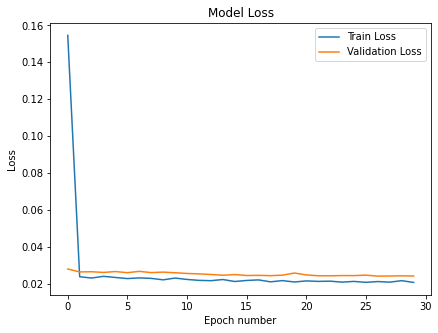

In [176]:
def plot_model_performace(history):
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch number')
  plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
  plt.show()

plt.figure(figsize=(15,5))
plot_model_performace(history)

In [177]:
predictions = model.predict(X_test_norm, verbose=True)

11/11 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


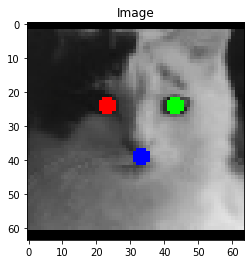

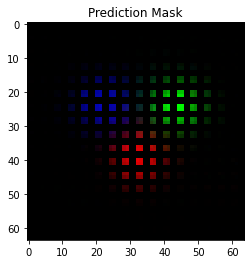

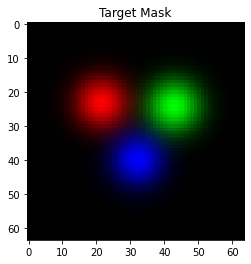

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


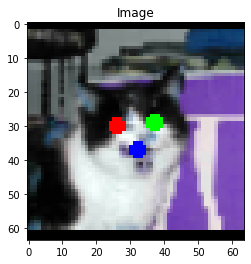

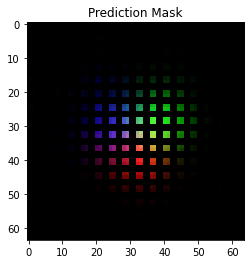

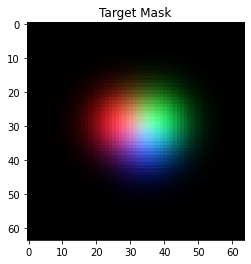

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


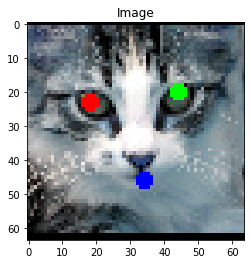

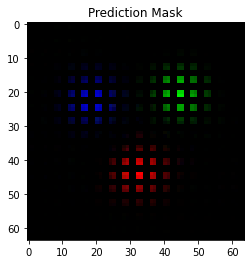

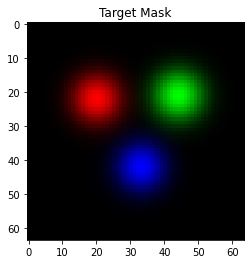

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


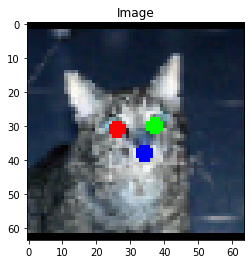

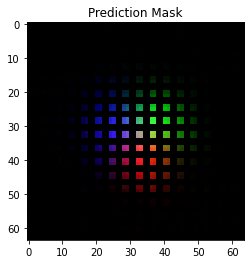

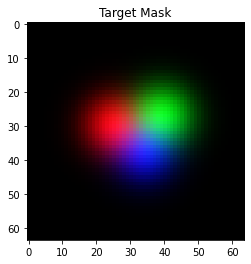

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


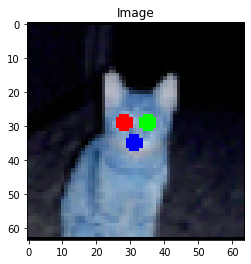

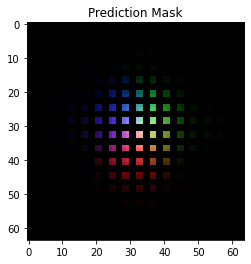

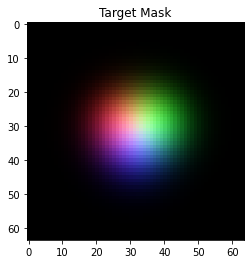

In [178]:
def get_image_statistics(channel_1, channel_2, channel_3):
  r, g, b = channel_1, channel_2, channel_3 
  x_r, x_g, x_b = range(0, r.shape[0]), range(0, g.shape[0]), range(0, b.shape[0])
  y_r, x_g, y_b = range(0, r.shape[1]), range(0, g.shape[1]), range(0, b.shape[1])
    
  (X_R, Y_R), (X_G, Y_G), (X_B, Y_B) = np.meshgrid(x_r, y_r), np.meshgrid(x_g, x_g), np.meshgrid(x_b, y_b)
  
  r_x_coord = (X_R*r).sum() / r.sum().astype("float")
  r_y_coord = (Y_R*r).sum() / r.sum().astype("float")
  
  g_x_coord = (X_G*g).sum() / g.sum().astype("float")
  g_y_coord = (Y_G*g).sum() / g.sum().astype("float")

  b_x_coord = (X_B*b).sum() / b.sum().astype("float")
  b_y_coord = (Y_B*b).sum() / b.sum().astype("float")

  r_center = (round(r_x_coord, 0).astype("int"), round(r_y_coord).astype("int"))
  g_center = (round(g_x_coord, 0).astype("int"), round(g_y_coord).astype("int"))
  b_center = (round(b_x_coord, 0).astype("int"), round(b_y_coord).astype("int"))
  return r_center, g_center, b_center

selected_images_indexes = np.random.choice(len(X_test_norm), 5)

for _, image_index in enumerate(selected_images_indexes):
  prediction = predictions[image_index]
  prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)

  red, green, blue = cv2.split(prediction)
  r_center, g_center, b_center =  get_image_statistics(channel_1 = red, channel_2 = green,channel_3 = blue)


  cv2.circle(X_test_norm[image_index], center=r_center, radius=1, color=(0, 0, 255), thickness=2)
  cv2.circle(X_test_norm[image_index], center=g_center, radius=1, color=(0, 255, 0), thickness=2)
  cv2.circle(X_test_norm[image_index], center=b_center, radius=1, color=(255, 0, 0), thickness=2)

  Image = prediction / np.amax(prediction)
  Image = np.clip(Image, 0, 1)

  plt.title("Image")
  plt.imshow(X_test_norm[image_index]);
  plt.show()

  plt.title("Prediction Mask")
  plt.imshow(Image);
  plt.show()
  
  plt.title("Target Mask")
  plt.imshow(test_label[image_index])
  plt.show()